# **Assignment 1: Data Pre-Processing**

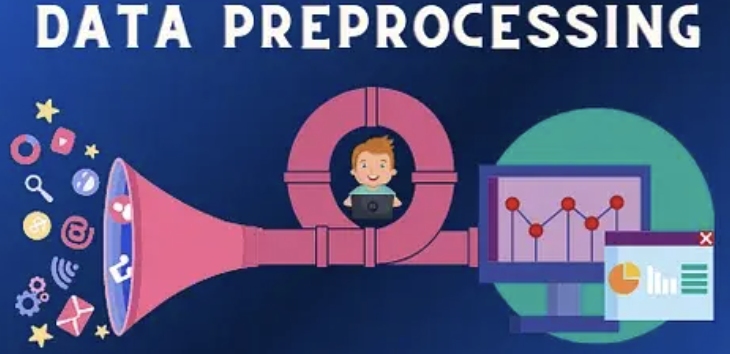

The main aim of the assignment is to help you understand the critical role of data pre-processing and image pre-processing in improving the performance of machine learning models. The assignment emphasizes hands-on experience in:

***Data Preprocessing:***

*   Cleaning and transforming raw data into a suitable format for analysis.
*   Reducing noise and redundancy through feature selection.
*   Analyzing the impact of preprocessing on structured data for supervised learning tasks.



# **Section 1: Data Processing: Arthritis Profile**

**Case study :** Arthritis is a chronic condition that affects millions globally, with severity levels ranging from mild to severe. Accurate classification of arthritis severity is critical for optimizing patient outcomes, as treatment plans can vary significantly based on the disease's progression. A healthcare provider wants to classify arthritis patients into different severity levels (e.g., mild, moderate, severe) based on their clinical, biochemical, and lifestyle data. By accurately predicting severity, the provider can recommend tailored treatments such as physical therapy, medications, or surgical interventions. For doing such analysis, we need to do following steps:

# **Step 1: Data Acquisition_ADP**

***Data Acquisitionb ( Collection) :*** Arthritis Profile dataset (ADP), corrsponding to this assignment,  was collected for one year from February 2021 to February 2022. Demographic data like age and gender, as well as Arthritis Profile investigations, were collected from the lab for the autoimmune arthritis disease study. Table 1 indicates the features or attributes in the APD dataset. The APD dataset consists of 24 features.

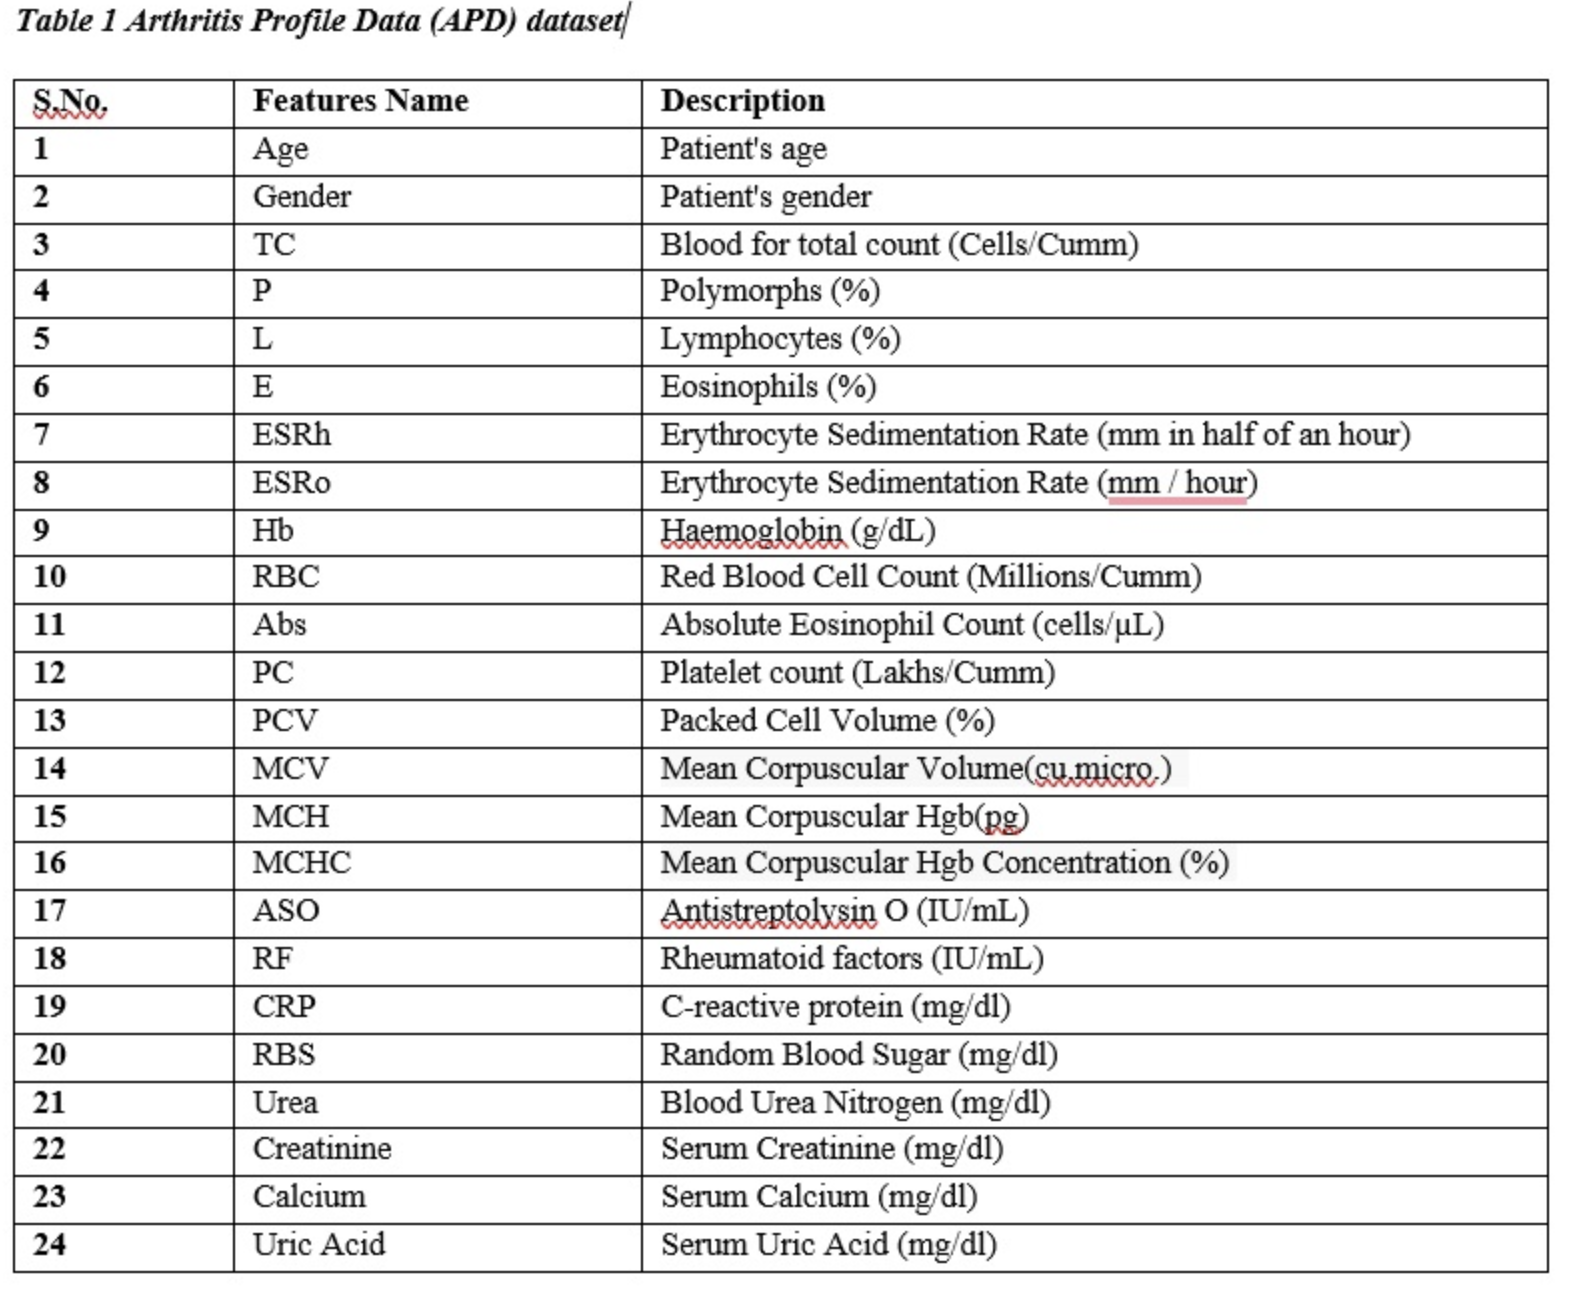

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

**Question1_ADP**:Using Python coding, read the file. Show the number of the samples, features, and what type of values each feature consist of(Discrete or Continous)?

In [5]:
# Load the dataset
# using pd.read_excel since the file is in .xlsx format can also use pd.read_csv if it was a CSV file.
file_path = "star_classification.csv"
df = pd.read_csv(file_path)

#dropping unnamed as it does not make any sense or gives any info
df= df.drop(df.columns[0], axis=1)

# checking out basic information about the dataset: rows and cols.
n_rows, n_cols = df.shape
print(f"Samples- rows {n_rows}")
print(f"Features- columns {n_cols}\n")

# taking a snapshot of data and reviewing it.
print("Preview first 10 rows:")
display(df.head(10))  
 
#missing values
null_counts = df.isna().sum()  
print("\nMissing values per column:")
display(null_counts)

#duplicates
dup_count = df.duplicated().sum() 
print(f"\nDuplicate rows: {dup_count}")

print("\nColumn data types:")
dtypes = df.dtypes  
display(dtypes)


Samples- rows 100000
Features- columns 17

Preview first 10 rows:


,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232



Missing values per column:


alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


Duplicate rows: 0

Column data types:


alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

In [6]:
# Discrete vs Continuous

# object / bool => Discrete
# integers => could be either Discrete (if few unique values) or Continuous
# floats => Continuous

# defining "few unique values"
# optA: fixed threshold like <=20 unique values
# optB: relative threshold like <=5% of total rows

# using a mix: max(20, 5% of rows) in such a way it scales with dataset size.
def feature_type(series: pd.Series, n_samples: int) -> str:
    if series.dtype == "bool":
        return "Discrete"
    if series.dtype == "object":
        return "Discrete"
    if isinstance(series.dtype, CategoricalDtype):   
        return "Discrete"
    if pd.api.types.is_integer_dtype(series):
        unique_vals = series.nunique(dropna=True)
        absolute_cap = 20
        relative_cap = max(5, int(0.05 * n_samples))  # avoids tiny thresholds
        return "Discrete" if unique_vals <= max(absolute_cap, relative_cap) else "Continuous"
    if pd.api.types.is_float_dtype(series):
        return "Continuous"
    return "Unknown"   # fallback, safety check

# applying it for all features
feature_types = {col: feature_type(df[col], n_rows) for col in df.columns}

print("\nFeature classification:")
for k, v in feature_types.items():
    print(f" - {k}: {v}")


Feature classification:
 - alpha: Continuous
 - delta: Continuous
 - u: Continuous
 - g: Continuous
 - r: Continuous
 - i: Continuous
 - z: Continuous
 - run_ID: Discrete
 - rerun_ID: Discrete
 - cam_col: Discrete
 - field_ID: Discrete
 - spec_obj_ID: Continuous
 - class: Discrete
 - redshift: Continuous
 - plate: Continuous
 - MJD: Discrete
 - fiber_ID: Discrete


Discrete features: 7
Continuous features: 10
Unknown features: 0


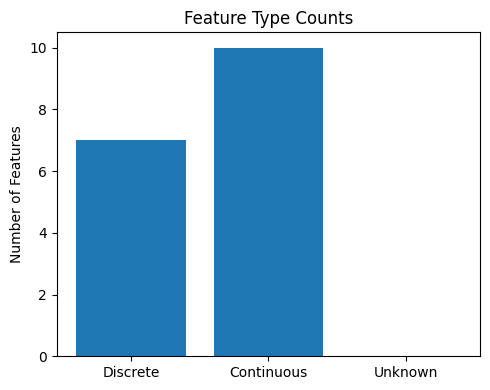

In [7]:

# visualizing features
discrete_cols = [c for c, t in feature_types.items() if t == "Discrete"]
continuous_cols = [c for c, t in feature_types.items() if t == "Continuous"]
unknown_cols = [c for c, t in feature_types.items() if t == "Unknown"]

print(f"Discrete features: {len(discrete_cols)}")
print(f"Continuous features: {len(continuous_cols)}")
print(f"Unknown features: {len(unknown_cols)}")

plt.figure(figsize=(5,4))
plt.bar(["Discrete", "Continuous", "Unknown"],
        [len(discrete_cols), len(continuous_cols), len(unknown_cols)])
plt.title("Feature Type Counts")
plt.ylabel("Number of Features")
plt.tight_layout()
plt.show()

Question 1 Summary
1. imported libraries and loaded data from excel.
2. reported dataset shape: rows and features.
3. did sanity checks: col data types, missing and duplicate value checks.

# **Step 2: Data Pre-Processing**

Data pre-processing is the process of transforming raw data into a clean, structured, and usable format for analysis or modeling. It is a crucial step in data science and machine learning to ensure the quality and reliability of the results. In this assignment, we only focus on data pre-processing. Please answer following questions. And, note that for every question, you need to briefly discuss your answer, and in case of coding, you to add comments for your codes.

**Note:** This data is not suitable for any type of training and modeling, because of limited number of samples.

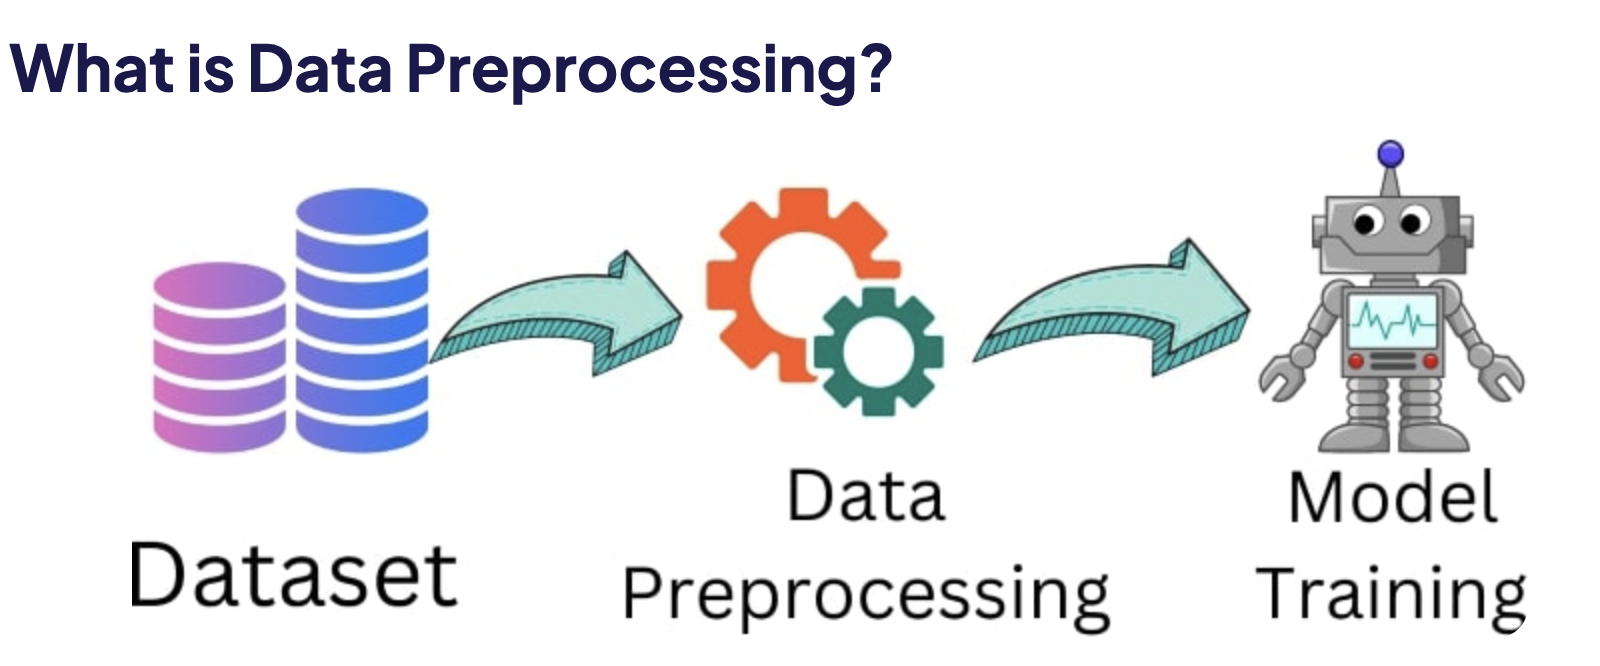

**Question 2_ADP:**

*2.1 Data Cleaning*: Detect if the data consist of any missing values or duplicate? what do you recommend? Develop it.

Also, using Box Plots, show if the data consist of any outliers?Analyze your results and discuss it briefly. And, provide a statistical description of your data for each feature, including mean, std, min, max, 25%, 50%, and 75%

Using Z-score, do you find any outliers?

Also, are we dealing with noisy data? Please elaborate your response. In case of yes, what do you recommend? Develop it.

[All have to be done by coding in python].

In [8]:

#using results from q1.
print("Missing values per column:")
display(null_counts)

print(f"\nDuplicate rows: {dup_count}")

#Missing values -drop if very few relative to the dataset, else impute (median for continuous, mode for discrete).
#Duplicates -drop as they don’t add new info.


Missing values per column:


alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


Duplicate rows: 0


Here we dont have any duplicate rows and also no missing values for discrete features, gender and label.

Thus will impute continuous features using median as it is less sensitive so it will represent the central tendency better than mean, can also go with KNN imputation but that would be too complex and unjustifiable for such small dataset.

In [9]:
df_clean = df.copy()

# for continuous features, impute with median
for col in continuous_cols:
    if df_clean[col].isna().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        
print("AFTER: Missing values per column")
display(df_clean.isna().sum() )

AFTER: Missing values per column


alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [10]:
print("\nStatistical numeric features:")
display(df_clean.describe().T)


Statistical numeric features:


,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,1.776291e+02,9.650224e+01,5.527828e-03,1.275182e+02,1.809007e+02,2.338950e+02,3.599998e+02
delta,100000.0,2.413530e+01,1.964467e+01,-1.878533e+01,5.146771e+00,2.364592e+01,3.990155e+01,8.300052e+01
u,100000.0,2.198047e+01,3.176929e+01,-9.999000e+03,2.035235e+01,2.217914e+01,2.368744e+01,3.278139e+01
g,100000.0,2.053139e+01,3.175029e+01,-9.999000e+03,1.896523e+01,2.109983e+01,2.212377e+01,3.160224e+01
r,100000.0,1.964576e+01,1.854760e+00,9.822070e+00,1.813583e+01,2.012529e+01,2.104478e+01,2.957186e+01
i,100000.0,1.908485e+01,1.757895e+00,9.469903e+00,1.773228e+01,1.940514e+01,2.039650e+01,3.214147e+01
z,100000.0,1.866881e+01,3.172815e+01,-9.999000e+03,1.746068e+01,1.900460e+01,1.992112e+01,2.938374e+01
run_ID,100000.0,4.481366e+03,1.964765e+03,1.090000e+02,3.187000e+03,4.188000e+03,5.326000e+03,8.162000e+03
rerun_ID,100000.0,3.010000e+02,0.000000e+00,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02
cam_col,100000.0,3.511610e+00,1.586912e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00


Here we skipped plotting boxplots for gender_m and label as they are discreate and don’t have natural ranges or continuous variation.


Boxplots


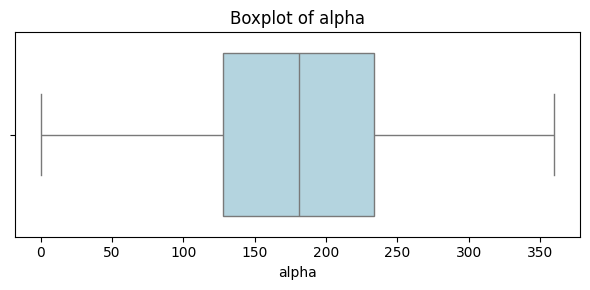

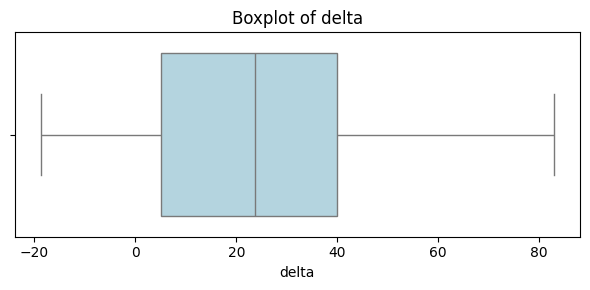

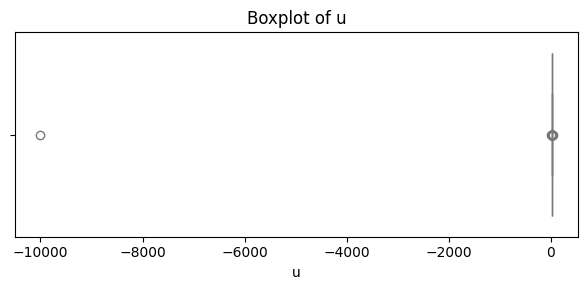

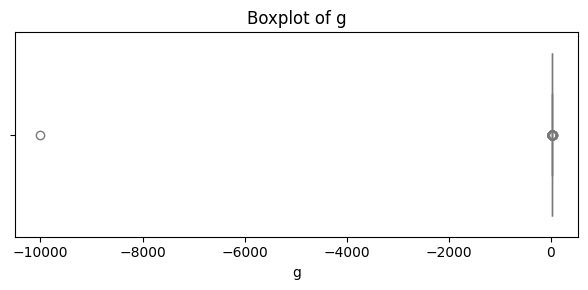

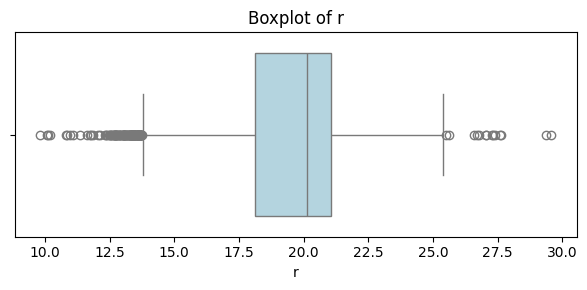

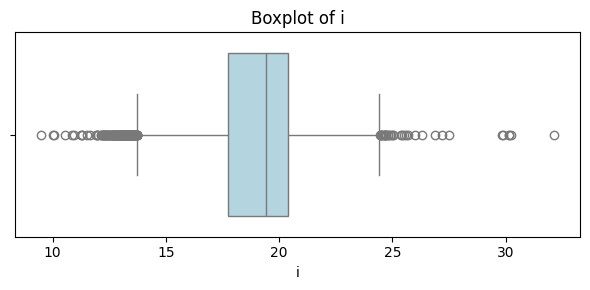

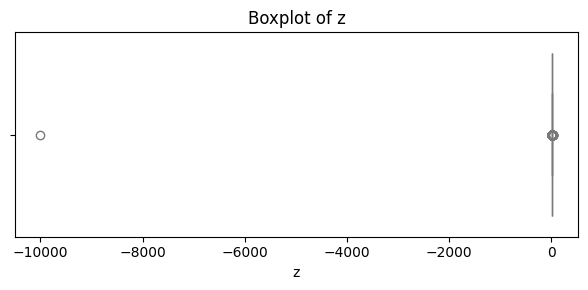

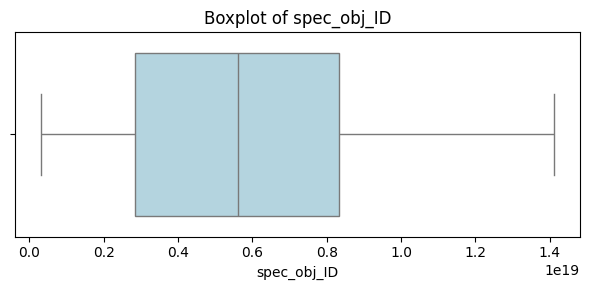

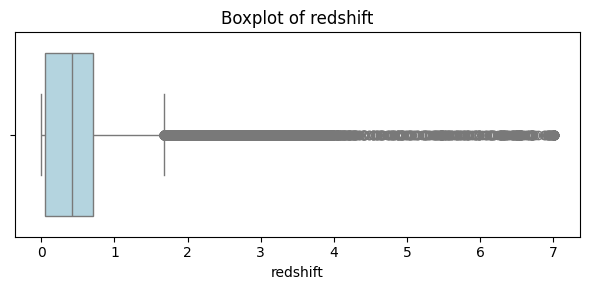

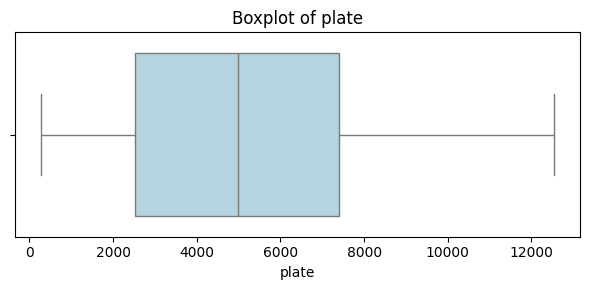

In [11]:
#plotting boxplots for finding outliers
print("\nBoxplots")
for col in continuous_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_clean[col], color="lightblue")
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()


Outlier counts per continuous feature (Z-score > 3):
 - alpha: 0 outliers
 - delta: 0 outliers
 - u: 1 outliers
 - g: 1 outliers
 - r: 193 outliers
 - i: 259 outliers
 - z: 1 outliers
 - spec_obj_ID: 0 outliers
 - redshift: 1836 outliers
 - plate: 0 outliers


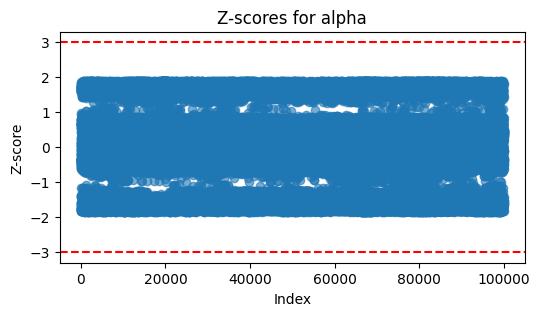

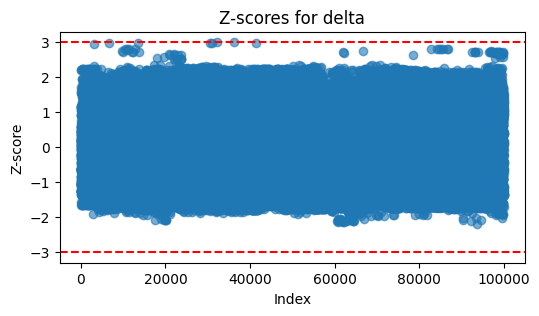

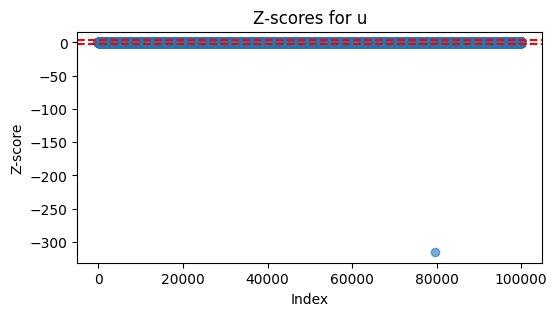

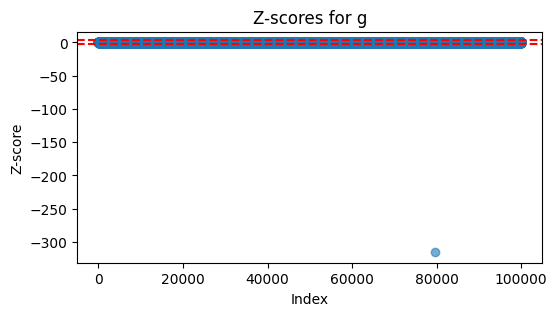

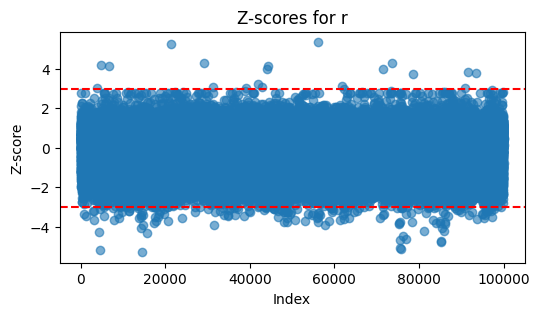

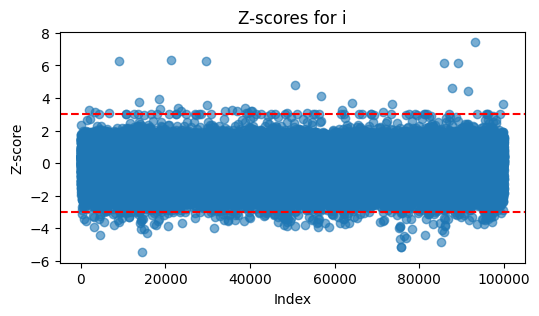

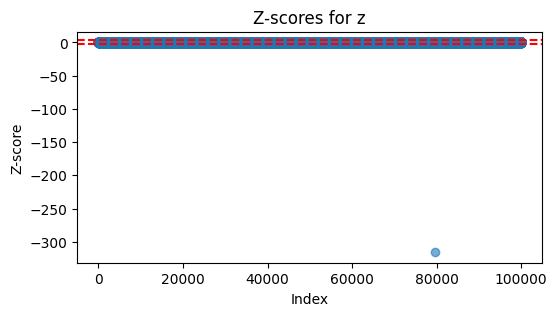

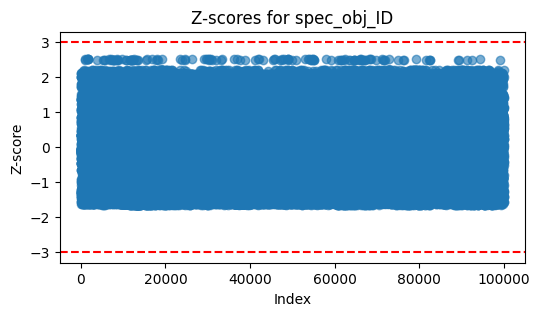

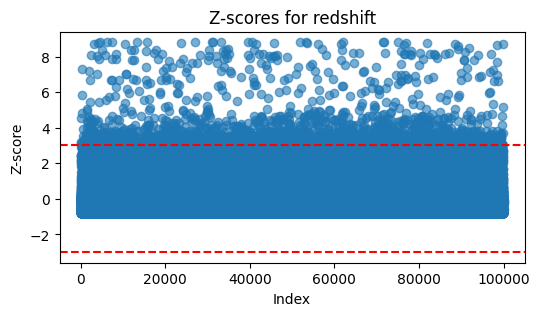

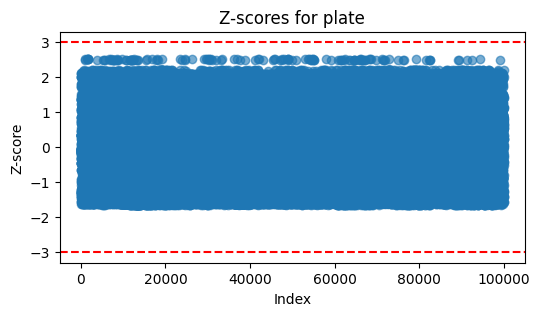

In [12]:
# Z-score calculation for finding outliers.
z_scores = np.abs(stats.zscore(df_clean[continuous_cols], nan_policy='omit'))
if z_scores.ndim == 1:  # handling single-col 
    z_scores = z_scores.reshape(-1, 1)
    
outlier_counts = (z_scores > 3).sum(axis=0)
print("\nOutlier counts per continuous feature (Z-score > 3):")
for col, count in zip(continuous_cols, outlier_counts):
    print(f" - {col}: {int(count)} outliers")

#visualising z score using scatter plot for better understanding.
for col in continuous_cols:
    plt.figure(figsize=(6,3))
    z = stats.zscore(df_clean[col], nan_policy='omit')
    plt.scatter(df_clean.index, z, alpha=0.6)
    plt.axhline(3, color="red", linestyle="--")
    plt.axhline(-3, color="red", linestyle="--")
    plt.title(f"Z-scores for {col}")
    plt.xlabel("Index")
    plt.ylabel("Z-score")
    plt.show()

Z-score analysis confirmed multiple extreme values across features. These are likely noisy points, as they deviate significantly from the mean distribution. I recommend considering winsorization or robust scaling to reduce their influence while preserving most of the data.

I came to this conclusion after analysing both z score and box plot visualization of ALL FEATURES. 


Applied Winsorization


KeyError: 'Age'

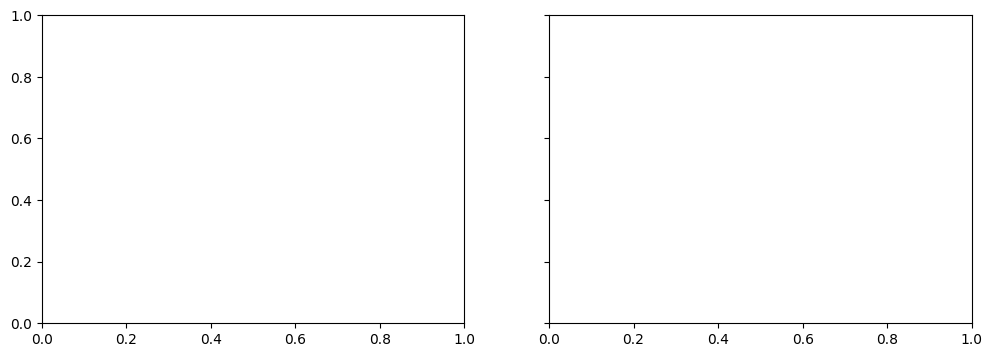

In [13]:
# winsorization: capping values at 5th–95th percentiles
df_winsor = df_clean.copy()

for col in continuous_cols:
    lower, upper = np.percentile(df_winsor[col].dropna(), [5, 95])
    df_winsor[col] = np.clip(df_winsor[col], lower, upper)

print("Applied Winsorization")

#taken from above results of z score.
outlier_features = [
    "Age","TC","ESRh","ESRo","Hb","RBC","PC","PCV","MCV","MCH",
    "MCHC","ASO","RA","CRP","RBS","Urea","Creatinine","Calcium"
]

#Z-score scatter before vs after Winsorization 
for col in outlier_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

    # Before
    z_before = stats.zscore(df_clean[col], nan_policy='omit')
    axes[0].scatter(df_clean.index, z_before, alpha=0.6)
    axes[0].axhline(3, color="red", linestyle="--")
    axes[0].axhline(-3, color="red", linestyle="--")
    axes[0].set_title(f"{col} - Before Winsorization")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Z-score")

    # After
    z_after = stats.zscore(df_winsor[col], nan_policy='omit')
    axes[1].scatter(df_winsor.index, z_after, alpha=0.6, color="green")
    axes[1].axhline(3, color="red", linestyle="--")
    axes[1].axhline(-3, color="red", linestyle="--")
    axes[1].set_title(f"{col} - After Winsorization")
    axes[1].set_xlabel("Index")

    plt.tight_layout()
    plt.show()

Although I applied median imputation to Calcium before winsorization, the feature had 91 missing values. Which caused most values to collapse into the median, making the column nearly constant. 

After winsorization, calcium appears as a straight line in Z-score plots confirming the lack of variability. 

Given this, Calcium is not informative and should either be dropped or interpreted with caution. 

I am dropping it to avoid noise and redundancy.

In [ ]:
df_winsor = df_winsor.drop(columns=["Calcium"])


**Question 3_ADP:**

*2.2 Data Transformation*: we want to normalize the data to improve the quality and remove the redundancy of the corresponding data. what do you recommend? develop it.

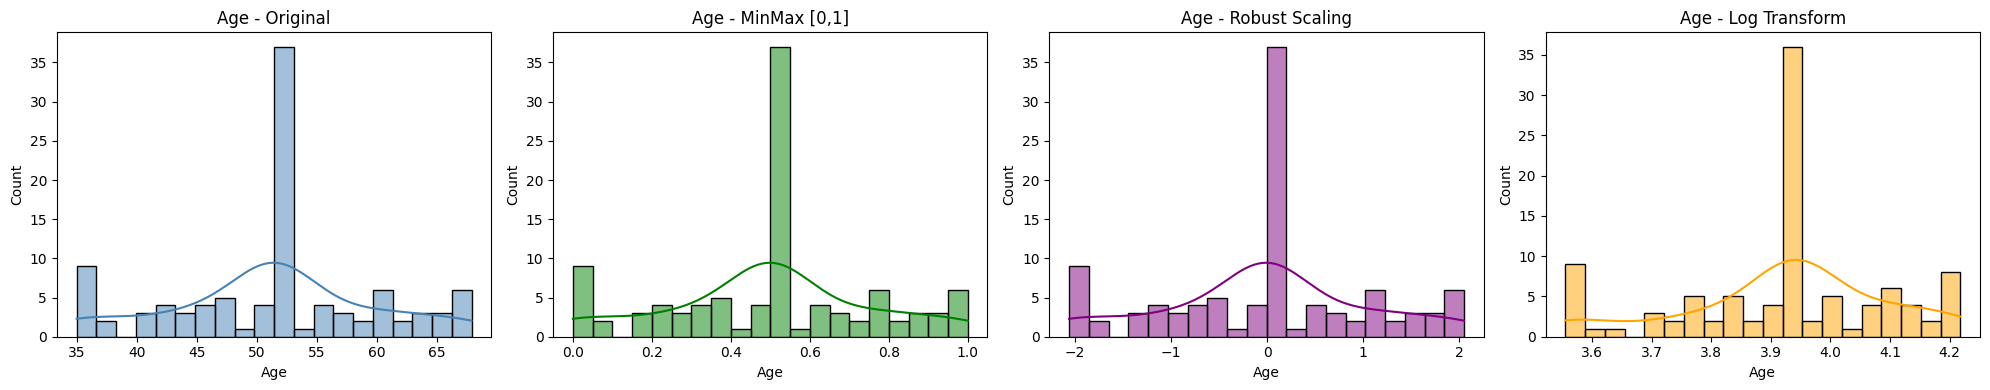

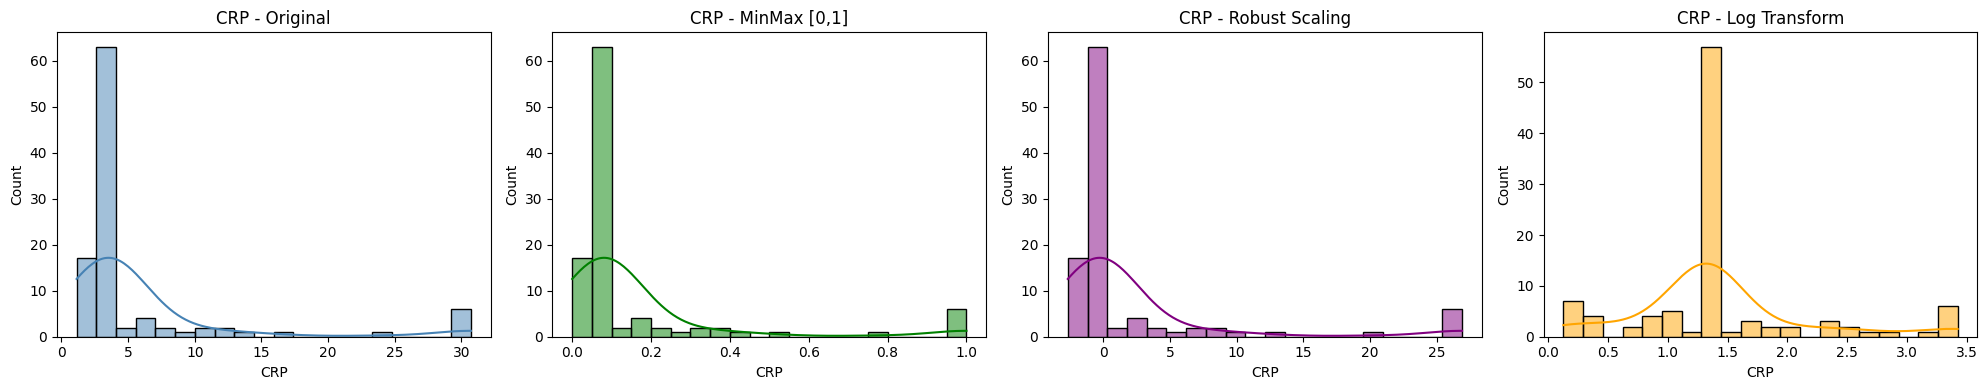

In [ ]:

# two sample continuous features to compare 
# CRP for skewed distribution, log helps.
# Age for near-normal distribution, Min–Max helps.
cols_to_compare = ["Age", "CRP"]

# Min-Max
scaler = MinMaxScaler()
df_minmax = df_winsor.copy()
df_minmax[cols_to_compare] = scaler.fit_transform(df_winsor[cols_to_compare])

# Log Transformation 
df_log = df_winsor.copy()
for col in cols_to_compare:
    min_val = df_winsor[col].min()
    shift = 1 - min_val if min_val <= 0 else 0
    df_log[col] = np.log(df_winsor[col] + shift) 
    
# Robust Scaling 
scaler_rb = RobustScaler()
df_robust = df_winsor.copy()
df_robust[cols_to_compare] = scaler_rb.fit_transform(df_winsor[cols_to_compare])

for col in cols_to_compare:
    fig, axes = plt.subplots(1, 4, figsize=(20,4))

    sns.histplot(df_winsor[col], bins=20, kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"{col} - Original")

    sns.histplot(df_minmax[col], bins=20, kde=True, ax=axes[1], color="green")
    axes[1].set_title(f"{col} - MinMax [0,1]")

    sns.histplot(df_robust[col], bins=20, kde=True, ax=axes[2], color="purple")
    axes[2].set_title(f"{col} - Robust Scaling")

    sns.histplot(df_log[col], bins=20, kde=True, ax=axes[3], color="orange")
    axes[3].set_title(f"{col} - Log Transform")

    plt.tight_layout()
    plt.show()


In this step I compared three transformation techniques: Robust Scaling, Min–Max Scaling, and Log Transformation.

Robust Scaling, which rescales using the median and IQR was less useful here because major outliers had already been handled in Q2 through winsorization. As a result, its main advantage was no longer relevant.

This left Min–Max Scaling and Log Transformation. Min–Max scaling is simple and preserves interpretability by mapping values into the [0,1] range, while log transformation is more effective for highly skewed features because it compresses large values and reduces skewness.

I compared all 3 methods on representative features (Age and CRP): Age, which is near-normal, was best handled by Min–Max scaling, while CRP, which is heavily skewed, benefited from log transformation. To keep preprocessing consistent across all continuous features, I selected Min–Max scaling as the final method.

**Question 4_ADP:**

*2.3 Imbalanced*: Can you specify the number of the samples in each class, and if it is imabalnced? can you visualize your majority and minority classes? Can you develop one undersampling and one oversampling techniques and explain about them.

Class distribution:
 Label
1    78
0    24
Name: count, dtype: int64


C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\1980824574.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


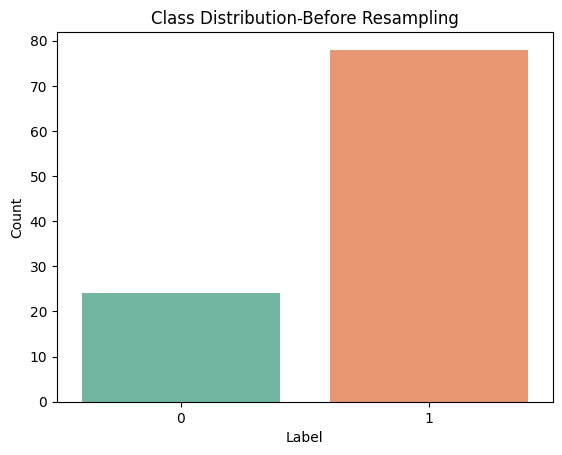


After Random Undersampling: Counter({0: 24, 1: 24})


C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\1980824574.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette="Set1")


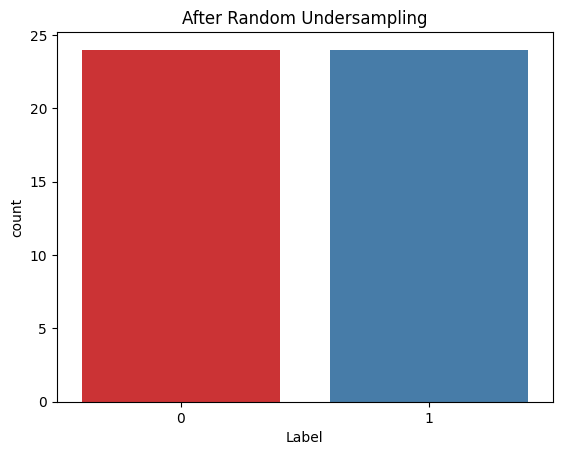


After SMOTE Oversampling: Counter({0: 78, 1: 78})


C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\1980824574.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_sm, palette="Set3")


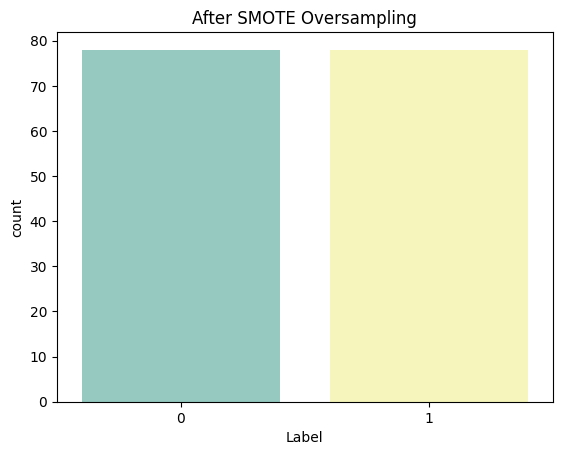

In [ ]:

# normalized data
X = df_minmax.drop(columns=["Label"])
y = df_minmax["Label"]

#  verifying class distribution
class_counts = y.value_counts()
print("Class distribution:\n", class_counts)

sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution-Before Resampling")
plt.ylabel("Count")
plt.show()

# undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print("\nAfter Random Undersampling:", Counter(y_res))

sns.countplot(x=y_res, palette="Set1")
plt.title("After Random Undersampling")
plt.show()

# oversampling (SMOTE)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)
print("\nAfter SMOTE Oversampling:", Counter(y_sm))

sns.countplot(x=y_sm, palette="Set3")
plt.title("After SMOTE Oversampling")
plt.show()


The dataset is imbalanced. Random undersampling provides balance by reducing data while SMOTE balances by creating synthetic samples. 

Given the very small dataset size, undersampling would waste information, so SMOTE oversampling is preferred for balancing the classes.

# **Step 3:Exploratory Data Analysis**

Exploratory Data Analysis (EDA) involves analyzing and summarizing the key characteristics of the dataset to uncover patterns, detect anomalies, and gain insights that inform subsequent modeling. For the Arthritis Profile Dataset, EDA is crucial to understand the relationships among clinical, biochemical, and lifestyle factors and their influence on arthritis severity.

**Question 5_ADP:**
What is the distribution of key biomarkers like CRP, ESRh and ESRo, and RF?

Is there a relationship between Age and Calcium?

Is there a significant relationship between gender and Red Blood Count?

Can you analyze your results? and what can you learn from these results?

[Note: you need to use visulization tools for discussing the relationships]

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
CRP,102.0,0.162330,0.237194,0.0,0.090119,0.090119,0.090119,1.000,2.846892,7.288127
ESRh,102.0,17.632353,9.193513,9.0,12.000000,13.000000,21.500000,39.750,1.328801,0.462184
ESRo,102.0,32.029412,15.730217,15.0,25.000000,25.000000,40.000000,69.500,1.155966,0.237440
RA,102.0,11.926706,5.897017,10.0,10.000000,10.000000,10.000000,34.709,3.501045,11.007654


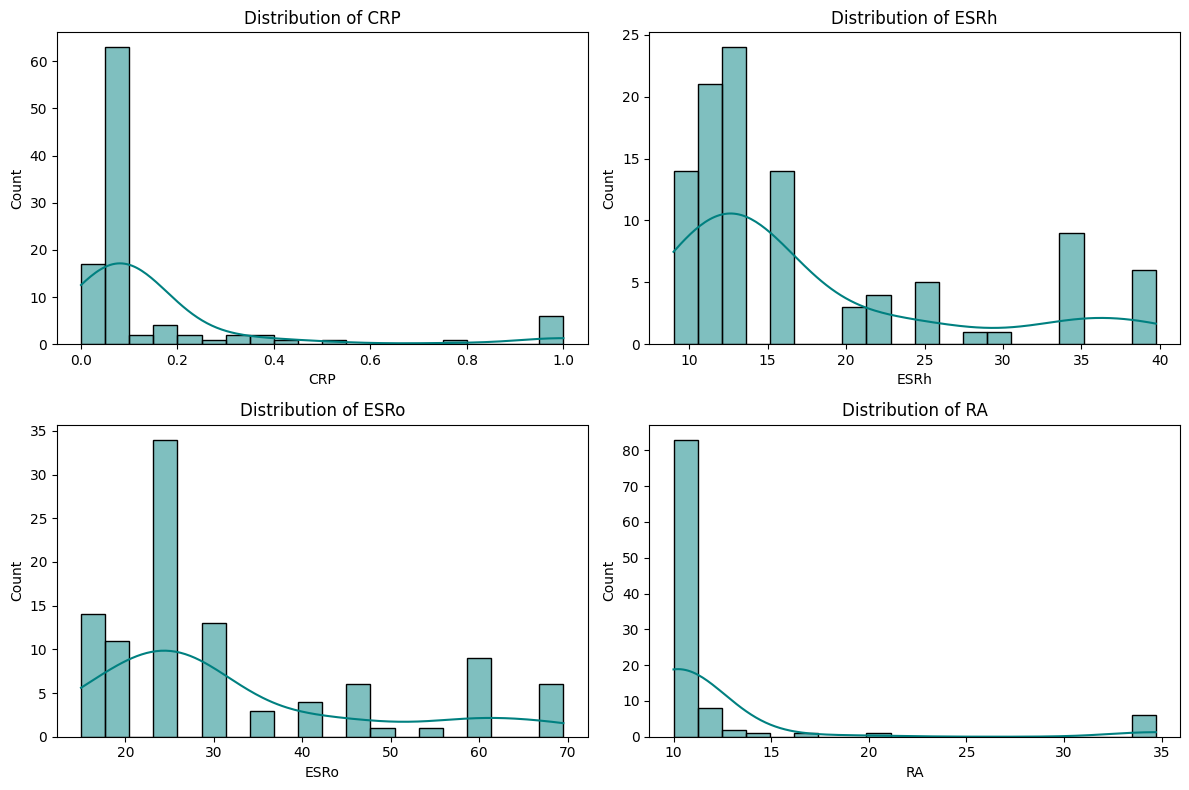

In [ ]:

# distribution of biomarkers

# statistics
biomarker_stats = df_minmax[["CRP", "ESRh", "ESRo", "RA"]].describe().T
biomarker_stats["skew"] = df_minmax[["CRP", "ESRh", "ESRo", "RA"]].skew()
biomarker_stats["kurtosis"] = df_minmax[["CRP", "ESRh", "ESRo", "RA"]].kurtosis()

display(biomarker_stats)

# histogram
biomarkers = ["CRP", "ESRh", "ESRo", "RA"]

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, col in enumerate(biomarkers):
    sns.histplot(df_minmax[col], bins=20, kde=True, color="teal", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

All four biomarkers are right-skewed, meaning most patients have low values while only a few show very high values. 

These high values are important as they may indicate stronger disease activity, with CRP and RA being more sensitive for detecting severe cases while ESRh and ESRo give similar information because they are strongly correlated.

Relationship between Age and Calcium

The Calcium feature had missing values and after median imputation it collapsed into nearly constant values. This was further confirmed in Winsorization, where Calcium showed up as a straight line in Z-score plots with no variability and thus we were not able to get infro from it so I decided to drop it to avoid noise and redundancy..

Thus, The lack of variability makes Calcium unreliable in this dataset and hence we have no relationship between age and calcium.

C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\2465757873.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender_M", y="RBC", data=df_minmax, palette="pastel")


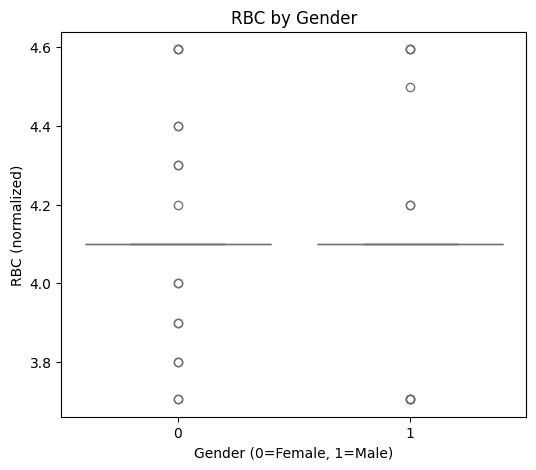

In [ ]:
# gender vs RBC boxplot
plt.figure(figsize=(6,5))
sns.boxplot(x="Gender_M", y="RBC", data=df_minmax, palette="pastel")
plt.title("RBC by Gender")
plt.xlabel("Gender (0=Female, 1=Male)")
plt.ylabel("RBC (normalized)")
plt.show()

Gender does not appear to influence RBC levels here as both male and female groups follow a very similar distribution.

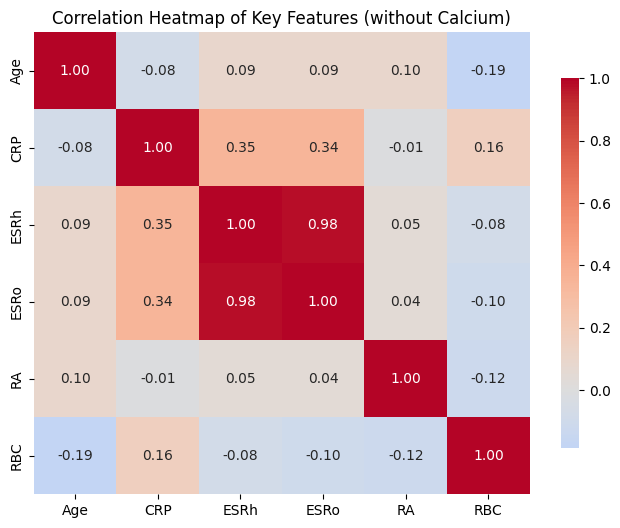

In [ ]:
# heatmap of correlations without calcium as we dropped it because it was not giving any context.
corr_matrix = df_minmax[["Age", "CRP", "ESRh", "ESRo", "RA", "RBC"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", cbar_kws={"shrink":0.8})
plt.title("Correlation Heatmap of Key Features (without Calcium)")
plt.show()


# **Step 4: Feature Engineering**
**Question 6_ADP**


**Part 4.1**: Using a Correlation technique, can you detect the correlated features by using heatmap? For finding sets of correlated features, you need to use a threshold.This Threshold is defined by developer. Here, consider the threshold 0.5. Generally, the correlation threshold will be over 0.9.

**Part 4.2**: Using Mutual information, idenity important features. visualize the score of each feature.

To summary, we need to remove correlated features from the corresponding data. Removing highly correlated features is a crucial preprocessing step in machine learning to improve model performance, interpretability, generalization, and computational efficiency. It helps create more robust and efficient models that are better suited for real-world applications.


**Part 4.3:** To remove correlated features, what do you recommend, conisdering Part 4.1 and Part 4.2?


Present the list of remaining features what you achieved in **Section 4.3**.

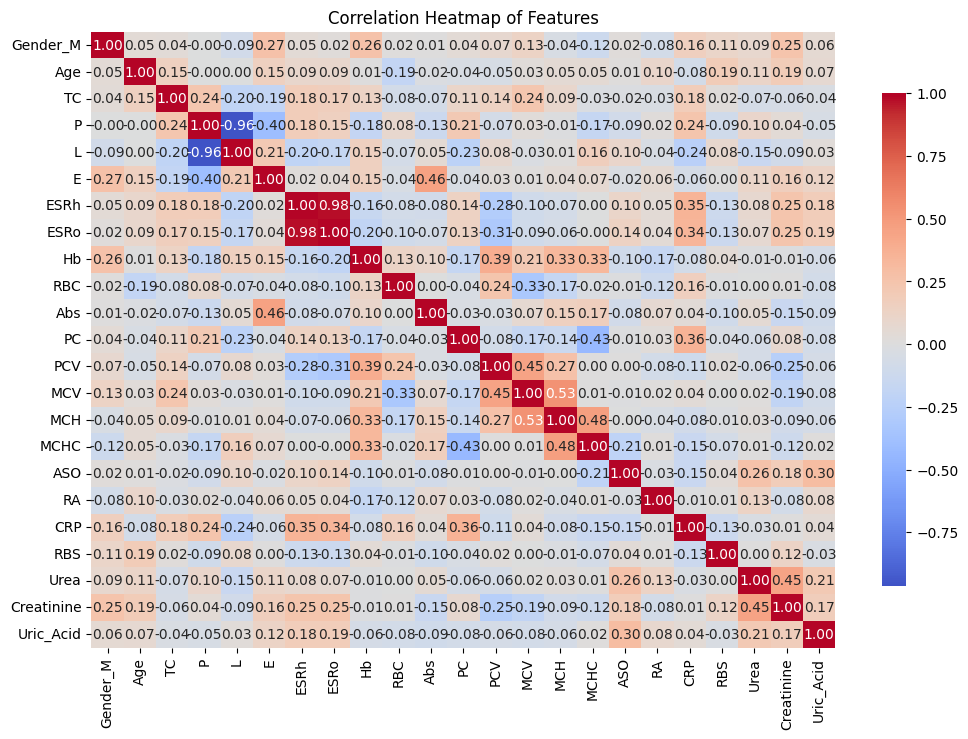

Correlated feature pairs (corr > 0.5):
     Feature1 Feature2  Correlation
63         P        L    -0.964219
117     ESRh     ESRo     0.976355
208      MCV      MCH     0.534192


In [ ]:

# droping label from correlation analysis as we only need feature-feature mapping.
corr_matrix = df_minmax.drop(columns=["Label"]).corr()


# plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
    center=0, cbar_kws={"shrink":0.8}
)
plt.title("Correlation Heatmap of Features")
plt.show()

# threshold-based correlated feature pairs
threshold = 0.5
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]

# filter pairs which exceeds threshold
high_corr = corr_pairs[abs(corr_pairs["Correlation"]) > threshold]
print("Correlated feature pairs (corr > 0.5):\n", high_corr)


The heatmap shows strong redundancy between ESRh and ESRo (0.98) and moderate overlap among MCV, MCH, and PCV which means these features carry almost the same information and we can drop one from each group.

C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\1228652092.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MI Score", y="Feature", data=mi_df, palette="viridis")


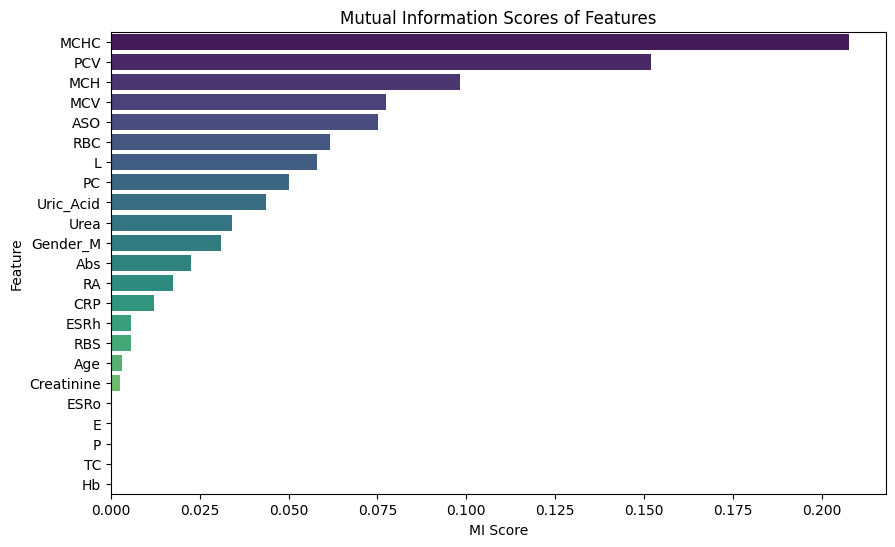

       Feature  MI Score
15        MCHC  0.207717
12         PCV  0.151856
14         MCH  0.098149
13         MCV  0.077428
16         ASO  0.075292
9          RBC  0.061779
4            L  0.057871
11          PC  0.050221
22   Uric_Acid  0.043629
20        Urea  0.034006
0     Gender_M  0.030909
10         Abs  0.022433
17          RA  0.017556
18         CRP  0.012033
6         ESRh  0.005674
19         RBS  0.005533
1          Age  0.003085
21  Creatinine  0.002655
7         ESRo  0.000259
5            E  0.000000
3            P  0.000000
2           TC  0.000000
8           Hb  0.000000


In [ ]:

# segregating features and target
X = df_minmax.drop(columns=["Label"])
y = df_minmax["Label"]

# mutual Information scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# create df for visualization
mi_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

# plotting MI scores
plt.figure(figsize=(10,6))
sns.barplot(x="MI Score", y="Feature", data=mi_df, palette="viridis")
plt.title("Mutual Information Scores of Features")
plt.show()

print(mi_df)


The analysis showed that some features like ESRh and ESRo are highly correlated which can cause redundancy. 

Mutual Information highlighted MCHC, PCV, MCH, MCV, ASO, and RBC as the most useful features while others like TC, Hb, and ESRo added little value. 

Keeping the important features and removing highly correlated ones will make the model more accurate and easier to interpret.

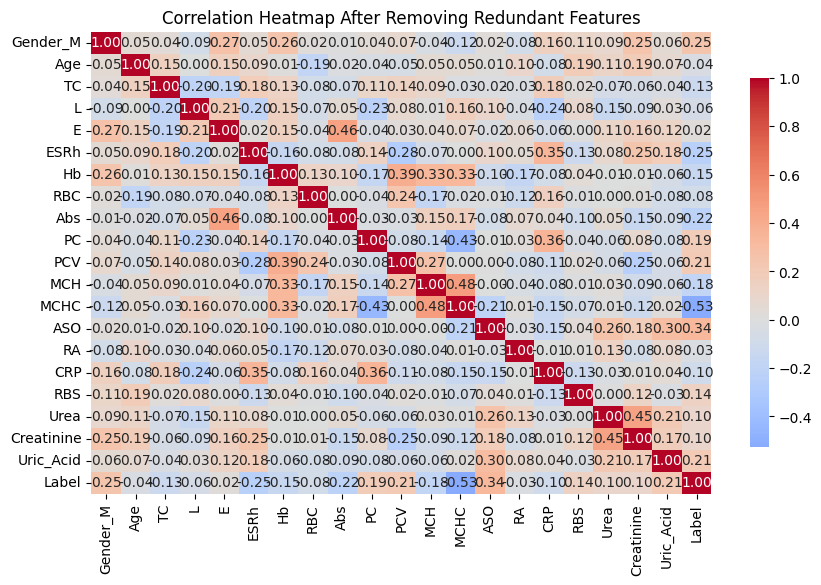

C:\Users\shiva\AppData\Local\Temp\ipykernel_7956\3031880655.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MI Score", y="Feature", data=mi_df_nonzero, palette="viridis")


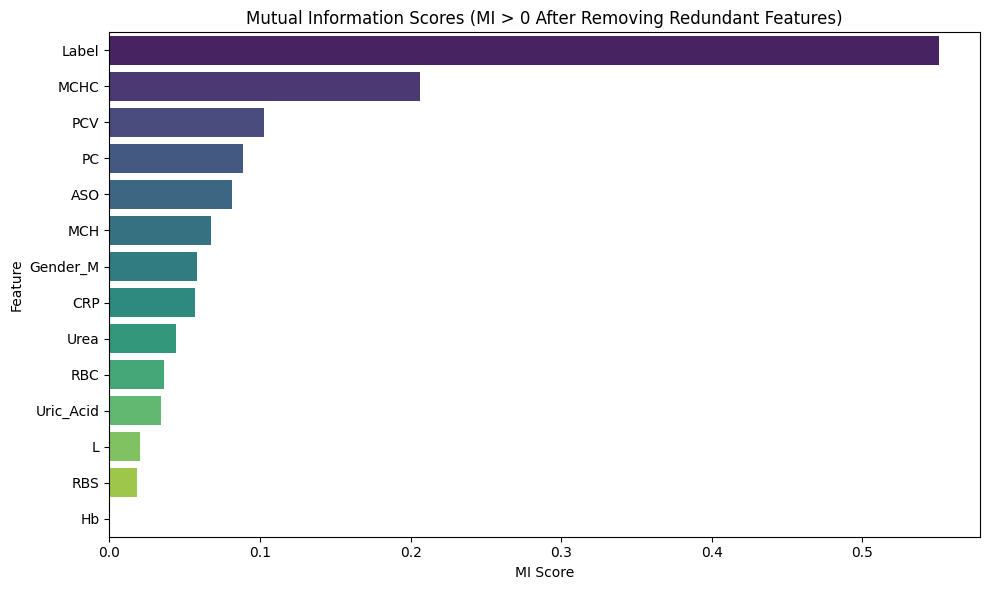

Final MI scores:
      Feature  MI Score
0       Label  0.550533
1        MCHC  0.206473
2         PCV  0.102438
3          PC  0.088551
4         ASO  0.081391
5         MCH  0.067741
6    Gender_M  0.058264
7         CRP  0.056877
8        Urea  0.044107
9         RBC  0.036394
10  Uric_Acid  0.034404
11          L  0.020552
12        RBS  0.018052
13         Hb  0.000234


In [ ]:

# removing correlated/redundant features
reduced_df = df_minmax.drop(columns=["Label", "ESRo", "MCV", "P"])  
# dropped ESRo (high corr, low MI), and dropped MCV (lower MI vs PCV & MCH)

# plotting heatmap after feature removal
corr_matrix_reduced = reduced_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(
    corr_matrix_reduced, annot=True, fmt=".2f", cmap="coolwarm", 
    center=0, cbar_kws={"shrink":0.8}
)
plt.title("Correlation Heatmap After Removing Redundant Features")
plt.show()

# MI after feature removal
X_reduced = reduced_df.copy()
y = df_minmax["Label"]

mi_scores_reduced = mutual_info_classif(X_reduced, y, random_state=42)

mi_df_reduced = (
    pd.DataFrame({"Feature": X_reduced.columns, "MI Score": mi_scores_reduced})
    .sort_values(by="MI Score", ascending=False)
    .reset_index(drop=True)
)

# keeping only features with MI > 0 
mi_df_nonzero = mi_df_reduced[mi_df_reduced["MI Score"] > 0].reset_index(drop=True)

# ploting for MI > 0 features
plt.figure(figsize=(10,6))
sns.barplot(x="MI Score", y="Feature", data=mi_df_nonzero, palette="viridis")
plt.title("Mutual Information Scores (MI > 0 After Removing Redundant Features)")
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# only MI > 0 
print("Final MI scores:")
print(mi_df_nonzero)


four features from the dataset were removed to avoid redundancy. 

The Label was dropped since it is not an input feature. 
ESRo was eliminated because it showed extremely high correlation with ESRh and carried almost no mutual information, making it redundant. 
MCV was excluded due to its overlap with MCH and PCV where it contributed less. 
P was dropped because it was almost perfectly correlated with L (–0.96), meaning both variables were capturing the same information. 



In [ ]:
df["RBS_Bin"] = pd.cut(
    df_minmax["RBS"],
    bins=[0, 70, 140, 200, 400], 
    labels=["Low", "Normal", "Prediabetes", "Diabetes"]
)

Binning groups raw values into clinically meaningful categories, making results easier to interpret as in how doctors classify blood sugar (normal, prediabetic, diabetic) instead of raw numbers.

In [ ]:
df["CRP_x_PCV"] = df_minmax["CRP"] * df_minmax["PCV"]


Multiplication focuses patients with both inflammation and abnormal blood volume which can signal severe conditions.

In [ ]:
df["MCHC_MCH_Ratio"] = df_minmax["MCHC"] / (df_minmax["MCH"] + 1e-5)


Ratio (MCHC/MCH) highlights red cell abnormalities more effectively than looking at each feature separately.

********************************************************

Now, our data is ready to start our model training and other necessary steps.


**Note:** For each question, be sure to discuss the answer technically and provide an analysis of the results.